# Melbourne Fire Hydrant Geographic Data visualisation Analysis Project

**Authored by**: Hanwen Dun

**Duration**: 90 mins  
**Level**: Intermediate  
**Pre-requisite Skills**: Python, pandas, folium, matplotlib  

## Objective

The goal of this use case is to analyse the spatial distribution and infrastructure of fire hydrants within a city using a real-world dataset. This involves examining hydrant types, identifying the most common street segments with hydrants, and visualizing their geographical locations on an interactive map. The analysis can assist with urban planning, fire safety infrastructure optimisation, and resource deployment strategies.

## Scenario

In this scenario, you take on the role of a data analyst working for the city’s public safety or infrastructure department. Your job is to understand:  

1. What types of fire hydrants are present?  

2. Where are hydrants most commonly located?  

3. Are there areas with potential data inconsistencies (e.g., missing street names)?  

4. How can this data be visualised on a map to aid infrastructure planning?  

By combining data cleaning, geospatial plotting, and categorical analysis, this assessment helps generate insights that can guide maintenance operations, urban fire response strategies, and infrastructure auditing.  

## What this use case will teach you

### At the end of this use case you will:

This use case provides hands-on experience in processing, cleaning, and visualizing spatial data. You will gain insights in:  

1. Infrastructure Typing: Understand the types of fire hydrants deployed and their relative frequencies (e.g., ground, above-ground, control valve).  

2. Spatial Hotspots: Identify streets or districts with high hydrant density, which could inform maintenance scheduling or fire safety planning.  
 
3. Data Quality Review: Spot and address missing or inconsistent location data, especially with key identifiers like street_segment_lupvalue.  


## Importing Required Libraries

In [124]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import time
import matplotlib.ticker as ticker
from geopy.geocoders import Nominatim
from IPython.display import IFrame
from io import StringIO
from matplotlib.lines import Line2D

## Importing the required dataset

In [82]:
# API base address
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'fire-hydrants'  

url = f'{base_url}{dataset_id}/exports/csv'

params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}

response = requests.get(url, params=params)

if response.status_code == 200:
    url_content = response.content.decode('utf-8')
    fire_hydrants_df = pd.read_csv(StringIO(url_content), delimiter=';')
    print(fire_hydrants_df.head())
else:
    print(f"Request failed with status code {response.status_code}")


   asset_number                                  asset_description  \
0       1615271  Fire Hydrant - Riverside Quay between Southban...   
1       1615275  Fire Hydrant - Southbank Promenade between Sou...   
2       1617367  Fire Hydrant - Intersection of Todd Road and W...   
3       1617460  Fire Hydrant - Intersection of City Road and B...   
4       1617412  Fire Hydrant - Punt Road between Tivoli Place ...   

  maintainer_lupvalue  marker_type_lupvalue object_type_lupvalue  \
0   City of Melbourne                   NaN         HYD_FIREPLUG   
1   City of Melbourne                   NaN          HYD_CONTROL   
2   City of Melbourne                   NaN         HYD_FIREPLUG   
3   City of Melbourne                   NaN         HYD_FIREPLUG   
4   City of Melbourne                   NaN         HYD_FIREPLUG   

   site_lupvalue                            street_segment_lupvalue  \
0            NaN  Riverside Quay between Southbank Boulevard and...   
1            NaN  Southbank 

This dataset provides detailed information about Melbourne's fire hydrant assets, including each hydrant's ID, geographic description, maintenance unit, equipment type, street location, and latitude and longitude coordinates. These fields enable in-depth analysis of the hydrants' geographic distribution, type composition, and relationship to roads. Some fields contain missing values and require further cleaning. This dataset can be used for analysis scenarios such as geographic visualisation, infrastructure management, and assessing a city's emergency response capabilities.

In [91]:
fire_hydrants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_number             307 non-null    int64  
 1   asset_description        307 non-null    object 
 2   maintainer_lupvalue      307 non-null    object 
 3   marker_type_lupvalue     0 non-null      float64
 4   object_type_lupvalue     307 non-null    object 
 5   site_lupvalue            0 non-null      float64
 6   street_segment_lupvalue  284 non-null    object 
 7   lat                      307 non-null    float64
 8   lon                      307 non-null    float64
 9   location                 307 non-null    object 
dtypes: float64(4), int64(1), object(5)
memory usage: 24.1+ KB


This information shows the basic structure and data quality of the fire hydrant dataset, comprising 307 records and 10 fields. These fields include asset number, description, maintenance unit, type information, and geographic location. While most fields have no missing values, the marker_type_lupvalue and site_lupvalue fields are completely missing, and the street_segment_lupvalue field is partially missing (having only 284 non-null values). This information is valuable for subsequent data cleaning, visualisation, and analysis.

## Dataset preprocessing

In [93]:
# Check for missing values
print("\nMissing values in Fire Hydrants Dataset:")
print(fire_hydrants_df.isnull().sum())


Missing values in Fire Hydrants Dataset:
asset_number                 0
asset_description            0
maintainer_lupvalue          0
marker_type_lupvalue       307
object_type_lupvalue         0
site_lupvalue              307
street_segment_lupvalue     23
lat                          0
lon                          0
location                     0
dtype: int64


This output shows the missing values in the fire hydrant dataset. The results show that most fields have complete data, but the marker_type_lupvalue and site_lupvalue fields are completely missing, with 307 missing records each. Additionally, the street_segment_lupvalue field has 23 missing records. The remaining fields, such as asset number, description, vascular unit, type information, and latitude and longitude, are complete. Subsequent analysis will focus on how to handle these fields with significant missing values, especially completely missing fields, which may require deletion or replacement.

In [86]:
# Reverse geocoding to fill missing values
geolocator = Nominatim(user_agent="fire_hydrant_street_filler")

missing_idx = fire_hydrants_df[fire_hydrants_df['street_segment_lupvalue'].isnull()].index

for idx in missing_idx:
    lat = fire_hydrants_df.at[idx, 'lat']
    lon = fire_hydrants_df.at[idx, 'lon']
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location and 'road' in location.raw.get('address', {}):
            street = location.raw['address']['road']
        else:
            street = "Unknown"
    except Exception as e:
        print(f"[✗] Index {idx}: Query failed → Unknown")
        street = "Unknown"

    fire_hydrants_df.at[idx, 'street_segment_lupvalue'] = street
    time.sleep(1)  

# Delete columns that are still empty
fire_hydrants_df = fire_hydrants_df.dropna(axis=1, how='all')

# Visual Map
fire_hydrants_cleaned = fire_hydrants_df.dropna(subset=['street_segment_lupvalue'])

map_center = [fire_hydrants_cleaned['lat'].mean(), fire_hydrants_cleaned['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=14, tiles='OpenStreetMap')

for _, row in fire_hydrants_cleaned.iterrows():
    location = [row['lat'], row['lon']]
    popup = folium.Popup(f"""
        <b>Description:</b> {row['asset_description']}<br>
        <b>Street:</b> {row['street_segment_lupvalue']}
    """, max_width=300)
    
    folium.Marker(
        location=location,
        popup=popup,
        icon=folium.Icon(color="red", icon="fire")
    ).add_to(m)

# Display the map directly
m

I used the geocoding tool Nominatim to automatically fill in missing street information (street_segment_lupvalue) in the fire hydrant dataset and removed any completely empty columns. We then created an interactive visualisation using folium, plotting all fire hydrants with street information on a map of Melbourne by their latitude and longitude, displaying the asset description and street name on each marker. This process improved data integrity and provided a visual representation of the geographic distribution of fire hydrants, facilitating subsequent analysis and decision-making regarding urban infrastructure layout.

In [98]:
# Check if street_segment_lupvalue still has missing values
missing_count = fire_hydrants_df['street_segment_lupvalue'].isnull().sum()
if missing_count == 0:
    print("All street_segment_lupvalue s have been successfully imputed with no missing values.")
else:
    print(f"There are still {missing_count} missing street_segment_lupvalue values.")

# Check again the distribution of missing values for the entire dataset
print("\nMissing value statistics for all fields：")
print(fire_hydrants_df.isnull().sum())


All street_segment_lupvalue s have been successfully imputed with no missing values.

Missing value statistics for all fields：
asset_number               0
asset_description          0
maintainer_lupvalue        0
object_type_lupvalue       0
street_segment_lupvalue    0
lat                        0
lon                        0
location                   0
dtype: int64


The latest test results show that all missing values in the street_segment_lupvalue field have been successfully imputed, and the entire dataset currently contains no missing items. The missing value statistics for all fields are 0, indicating that the data has been completely cleaned, laying a solid foundation for subsequent geographic analysis and visualisation.

## Fire hydrant data visualisation analysis

### Fire hydrant type distribution

C:\Users\dhw15\AppData\Local\Temp\ipykernel_7992\4124102197.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=type_counts.values, y=type_counts.index, palette="Blues_d")


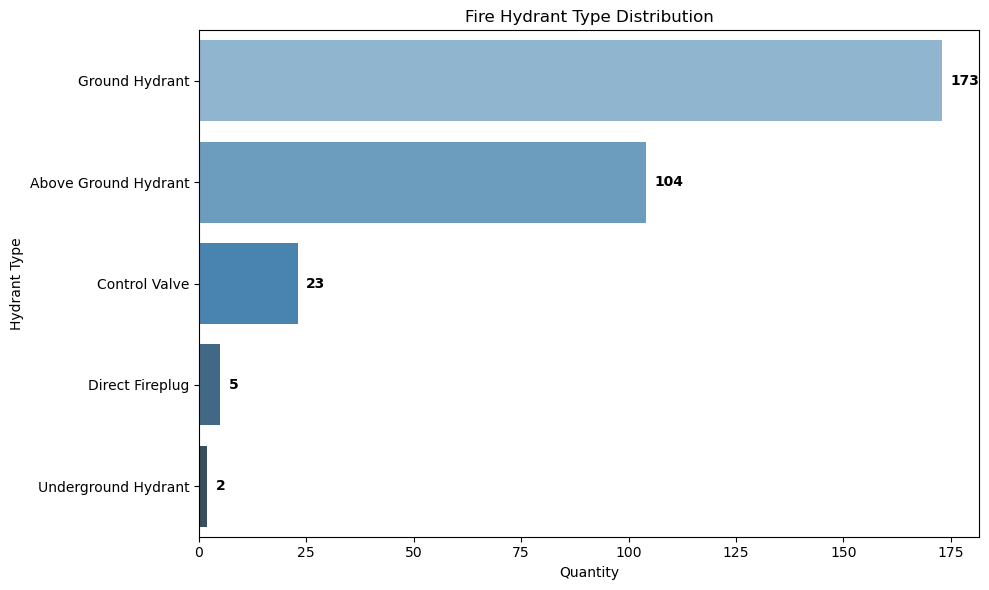

In [80]:
# Mapping codes to labels
type_mapping = {
    'HYD_FIREPLUG': 'Ground Hydrant',
    'HYD_ABOVE': 'Above Ground Hydrant',
    'HYD_CONTROL': 'Control Valve',
    'HYD_FIREPLUG_DIRECT': 'Direct Fireplug',
    'HYD_BELOW': 'Underground Hydrant'
}

# Create a copy and replace the field value
df_plot = fire_hydrants_df.copy()
df_plot['hydrant_type'] = df_plot['object_type_lupvalue'].map(type_mapping)

# Count the number of
type_counts = df_plot['hydrant_type'].value_counts()

# Drawing
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=type_counts.values, y=type_counts.index, palette="Blues_d")

# Add quantity label
for i, v in enumerate(type_counts.values):
    ax.text(v + 2, i, str(v), color='black', va='center', fontweight='bold')

# Title and axis labels
plt.title("Fire Hydrant Type Distribution")
plt.xlabel("Quantity")
plt.ylabel("Hydrant Type")
plt.tight_layout()
plt.show()

This data shows the distribution of different types of firefighting facilities in Melbourne. The results show that ground hydrants and above-ground hydrants are the two most common types, accounting for 173 and 104, respectively, making up the majority. Control valves, direct fire plugs, and underground hydrants are less common, with 23, 5, and 2, respectively. This distribution reflects the city's preference for firefighting facility deployment and can help relevant departments make more informed decisions regarding resource allocation and urban safety management.

### Streets with the most fire hydrants

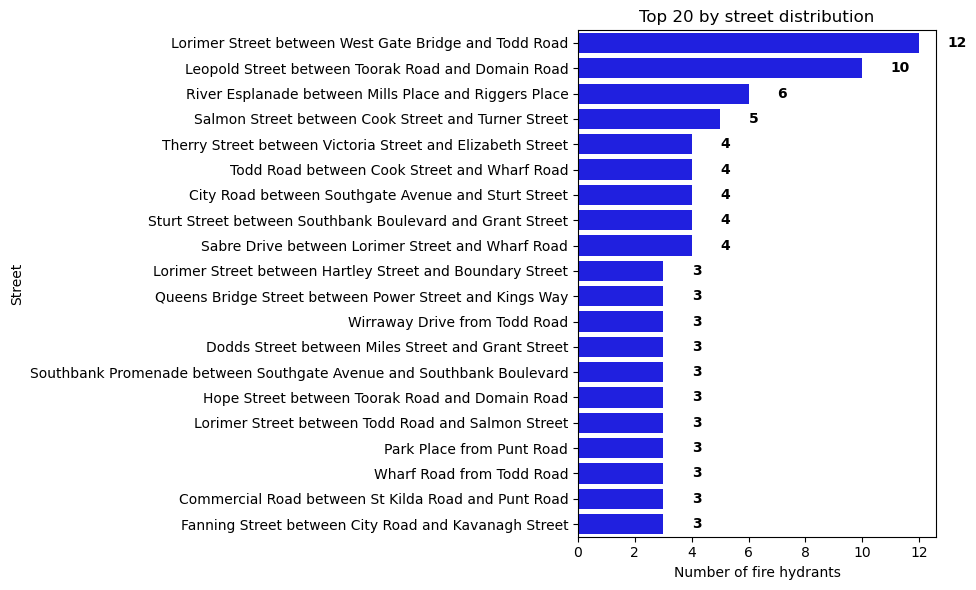

In [21]:
plt.figure(figsize=(10, 6))

# Count the top 20 streets
top_streets = fire_hydrants_df['street_segment_lupvalue'].value_counts().head(20)

# Draw a horizontal bar chart
ax = sns.barplot(x=top_streets.values, y=top_streets.index, color='blue')

# Add quantity labels to each column
for i, v in enumerate(top_streets.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

# Set title and label
plt.title("Top 20 by street distribution")
plt.xlabel("Number of fire hydrants")
plt.ylabel("Street")
plt.tight_layout()
plt.show()

This map details the spatial distribution of fire hydrants at the street level in Melbourne, showing the top 20 streets by hydrant count. Lorimer Street and Leopold Street have the highest hydrant densities, with 12 and 10 hydrants, respectively. This suggests these areas may be transportation hubs or densely populated areas, requiring enhanced fire safety. While streets ranked lower in the rankings have fewer hydrants, they also demonstrate some fire safety coverage. Overall, this distribution reveals the key priorities for firefighting resources, providing important guidance for optimizing equipment maintenance and emergency route planning.

### Longitude distribution of fire hydrants

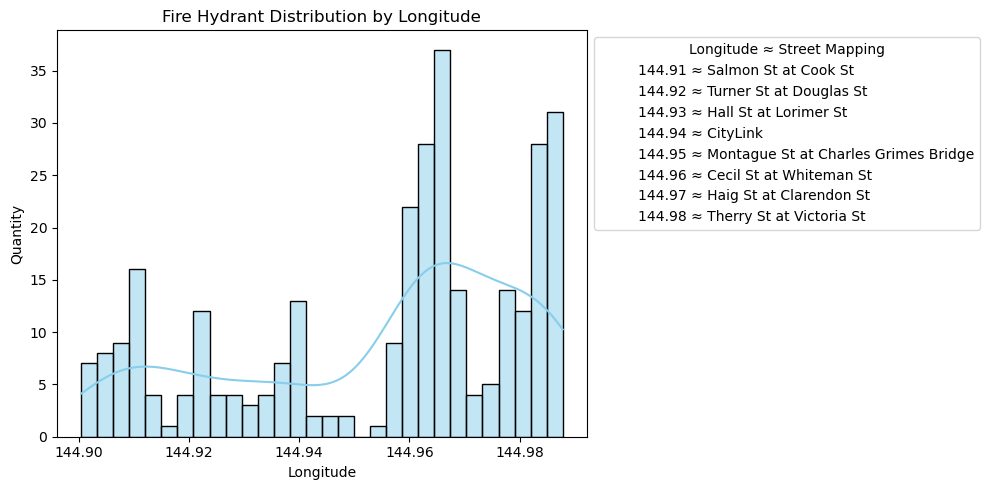

In [ ]:
# Create a graph
plt.figure(figsize=(10, 5))

# Draw histogram and KDE curve
sns.histplot(fire_hydrants_df['lon'], bins=30, kde=True, label='Hydrant Count', color='skyblue')

# Set title and label
plt.title("Fire Hydrant Distribution by Longitude")
plt.xlabel("Longitude")
plt.ylabel("Quantity")

# Street and longitude mapping instructions
custom_labels = [
    "144.91 ≈ Salmon St at Cook St",
    "144.92 ≈ Turner St at Douglas St",
    "144.93 ≈ Hall St at Lorimer St",
    "144.94 ≈ CityLink",
    "144.95 ≈ Montague St at Charles Grimes Bridge",
    "144.96 ≈ Cecil St at Whiteman St",
    "144.97 ≈ Haig St at Clarendon St",
    "144.98 ≈ Therry St at Victoria St"
]



# Create transparent lines as legend items
custom_lines = [Line2D([0], [0], color='black', lw=0, label=label) for label in custom_labels]

# Add a legend
plt.legend(handles=custom_lines, title="Longitude ≈ Street Mapping", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Distribution Analysis

The histogram shows significant differences in the distribution of fire hydrants by longitude. The number of fire hydrants increases significantly between 144.95 and 144.98, peaking at nearly 40 near 144.96 (Cecil St at Whiteman St), suggesting a high-density commercial or residential area with a high demand for fire safety. Meanwhile, the number of fire hydrants decreases rapidly between 144.93 (Hall St at Lorimer St) and 144.94 (CityLink), likely due to highways or undeveloped areas, where the need for fire hydrants is low. Furthermore, there is a slight increase between 144.91 and 144.92 (Salmon St and Turner St), but the overall number remains low, suggesting moderate or more evenly distributed demand in these areas.

KDE curve observation

The kernel density estimation curve further reveals the distribution trends of fire hydrants at different longitudes. As can be seen, the KDE curve forms a significant peak near 144.96, corresponding to the highest number of fire hydrants in the histogram, indicating a hotspot. Conversely, the curve dips near 144.94, corresponding to the CityLink Expressway section, confirming the relatively limited infrastructure coverage in this area. Furthermore, the KDE curve flattens at its extremes (144.91 and 144.99), indicating that the number of fire hydrants in these marginal areas is sparsely distributed and exhibits little variation. The KDE curve provides a visual understanding of the locations where firefighting facilities are concentrated, facilitating the scheduling and optimised layout of urban firefighting resources.

### Fire hydrant density heat map

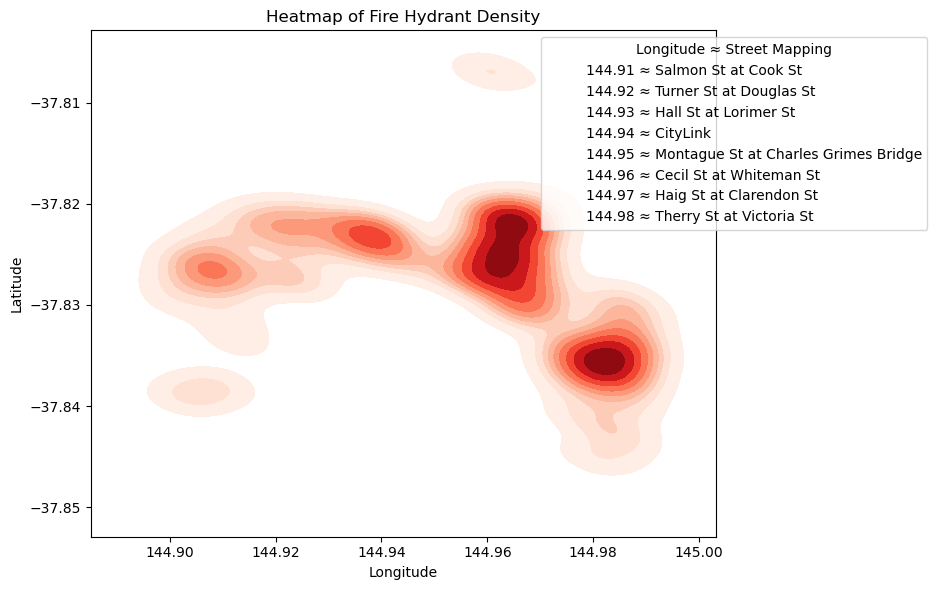

In [130]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=fire_hydrants_df['lon'], 
    y=fire_hydrants_df['lat'], 
    cmap="Reds", 
    fill=True, 
    bw_adjust=0.5
)

plt.title("Heatmap of Fire Hydrant Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Set the longitude display format to ordinary decimals
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Define legend
custom_labels = [
    "144.91 ≈ Salmon St at Cook St",
    "144.92 ≈ Turner St at Douglas St",
    "144.93 ≈ Hall St at Lorimer St",
    "144.94 ≈ CityLink",
    "144.95 ≈ Montague St at Charles Grimes Bridge",
    "144.96 ≈ Cecil St at Whiteman St",
    "144.97 ≈ Haig St at Clarendon St",
    "144.98 ≈ Therry St at Victoria St"
]

custom_lines = [Line2D([0], [0], color='black', lw=0, label=label) for label in custom_labels]

plt.legend(
    handles=custom_lines,
    title="Longitude ≈ Street Mapping",
    loc='upper right',
    bbox_to_anchor=(1.35, 1)
)

plt.tight_layout()
plt.show()


This heat map shows the spatial density of fire hydrants across longitude and latitude. The colour gradient from light red to dark red indicates increasing hydrant density, with dark red areas representing the highest concentrations. High hydrant density is primarily concentrated near the following longitudes: 144.95 to 144.96 (near Montague and Cecil Streets) and 144.97 to 144.98 (near Haig and Therry Streets). These areas exhibit distinct red density peaks, indicating a high density of fire hydrants around these streets and intersections, likely due to commercial areas, transportation hubs, or high population density.  

Meanwhile, the western area between longitudes 144.91 to 144.93 (Salmon and Hall Streets) exhibits a relatively moderate density, indicating a relatively balanced distribution of hydrants within the area. Near 144.94 (CityLink), fire hydrants are relatively sparsely distributed and show less intense heat, likely due to being located on a city highway or in an area with few people. Furthermore, the legend used in the chart greatly enhances readability and spatial reference by labelling key longitudes with their corresponding streets (e.g., "144.97 ≈ Haig St at Clarendon St"), making it easier to compare hotspots with actual locations and facilitate further planning.